# Gaussian processes with outliers

Suppose there are data distributed according a noisy Gaussian process with outliers at places.
Doing inference with outliers renders the inference useless, and is indeed where point-wise marginal likelihood maximisation falls flat on its face.
With JAXNS we can marginalise over hyper parameters as easily as defining them as prior RVs and marginalising over the posterior.

A Gaussian process is defined by a covariance function, $K : \mathcal{X} \times \mathcal{X} \to \mathbb{R}$, and a mean function $\mu : \mathcal{X} \to \mathbb{R}$.
Given the above data we see that it is equivalent to a Gaussian likelihood, with Gaussian process prior,

$L(x) = p(y | x) = \mathcal{N}[y \mid x, \Sigma]$

and

$p(x) = \mathcal{N}[x \mid \mu(X), K(X,X)]$

where $\mu(X)$ and $K(X,X)$ are the mean and covariance functions evaluated over the coordinate locations of the data.

The evidence of this model is well known,

$Z \triangleq p(y) = \int_\mathcal{X} L(x) p(x) \,\mathrm{d} x = \mathcal{N}[y \mid \mu(X), K(X,X) + \Sigma)$

and likewise the posterior distribution is,

$p(x \mid y) = \mathcal{N}[x \mid \mu', K']$

where

$\mu' = \mu(X) + K(X,X) (K(X,X) + \Sigma)^{-1}(y - \mu(X))$

and

$K' = K(X,X) - K(X,X) (K(X,X) + \Sigma)^{-1} K(X,X)$

## Marginalisation

The mean and covariance functions are not _a priori_ known and thus we must infer them as well.
Let the hyper parameters of the mean and covariance functions, and the noise covariance be $\theta$, and suppose we wish to infer their values.
The likelihood then becomes,

$p(y \mid \theta) = \int_\mathcal{X} L(x | \theta) p(x) p(\theta) \,\mathrm{d} x = \mathcal{N}[y \mid \mu_\theta(X), K_\theta(X,X) + \Sigma_\theta)$

where we recognise this as the marginal likelihood.

Now suppose we wish to predict $x$ at new points $X' \subset \mathcal{X}$, then this equivalent to sampling from the marginalised predictive posterior,

$$p(x(X') | y) = \int p(x(X') \mid x(X)) p(x(X) \mid y, \theta) p(y \mid \theta) p(\theta) \mathrm{d} \theta \mathrm{d} x(X)\\
= \mathbb{E}_{\theta \mid y}[p(x(X') \mid x(X)) p(x(X) \mid y, \theta) \mathrm{d} x(X)]$$

Now since $p(x(X') \mid x(X))$ and $p(x(X) \mid y, \theta)$ are both Gaussians, their product is also a Gaussian, and is given by,

$$p(x(X') \mid x(X)) p(x(X) \mid y, \theta) = \mathcal{N}[x(X') \mid K(X',X)K(X,X)^{-1} x(X), K(X',X') - K(X',X)K(X,X)^{-1}K(X,X')] \mathcal{N}[x(X) \mid \mu', K']\\
\implies \int p(x(X') \mid x(X)) p(x(X) \mid y, \theta) \mathrm{d} x(X) = \mathcal{N}[x(X') \mid m, S]$$

where

$m = K(X',X)K(X,X)^{-1} \mu'$

and

$S = K(X',X')  + K(X',X) (K(X,X)^{-1} K' K(X,X)^{-1} -  K(X,X)^{-1})K(X,X')$

Therefore, sampling from the marginalised predictive distribution is equivalent to sampling $\theta \sim p(\theta \mid y)$, and then sampling $x(X') \sim \mathcal{N}[x(X') \mid m, S]$.

## Overview

We'll cover the following topics:

1. How to formulate a Gaussian process prior.
2. How to compute samples from the marginalised distribution
3. How to compute the marginalised mean and variance of the distribution

In [1]:
from jaxns import NestedSampler, PriorChain, UniformPrior, HalfLaplacePrior, GaussianProcessKernelPrior
from jaxns import plot_cornerplot, plot_diagnostics
from jaxns.modules.gaussian_process.kernels import RBF, M12, M32
from jaxns import marginalise_dynamic, summary
from jax.scipy.linalg import solve_triangular
from jax import random, jit
from jax import numpy as jnp
import pylab as plt
import numpy as np

# for Gaussian processes this is important
from jax.config import config
config.update("jax_enable_x64", True)

WARNING[2022-04-06 17:04:07,983]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


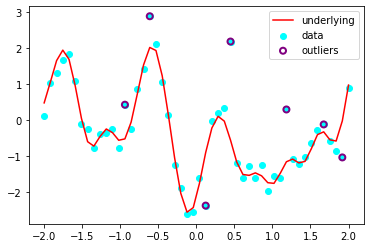

In [2]:
N = 50
num_outliers = int(0.15*N)
np.random.seed(42)
X = jnp.linspace(-2., 2., N)[:, None]
true_sigma, true_l, true_uncert = 1., 0.2, 0.2
data_mu = jnp.zeros((N,))
prior_cov = RBF()(X, X, true_l, true_sigma) + 1e-13 * jnp.eye(N)

Y = jnp.linalg.cholesky(prior_cov) @ random.normal(random.PRNGKey(42), shape=(N,)) + data_mu
Y_obs = Y + true_uncert * random.normal(random.PRNGKey(1), shape=(N,))
outliers_mask = jnp.where(jnp.isin(jnp.arange(N), np.random.choice(N, num_outliers, replace=False)), jnp.asarray(True), jnp.asarray(False))
Y_obs = jnp.where(outliers_mask,
                  random.laplace(random.PRNGKey(1), shape=(N,)),
                  Y_obs)
plt.plot(X[:,0], Y, c='red', label='underlying')
plt.scatter(X[:,0], Y_obs, c='cyan', label='data')
plt.scatter(X[outliers_mask,0], Y_obs[outliers_mask], label='outliers',facecolors='none',edgecolors='purple', lw=2)
plt.legend()
plt.show()


In [3]:


def run_for_kernel(kernel):
    print(("Working on Kernel: {}".format(kernel.__class__.__name__)))

    def log_normal(x, mean, cov):
        L = jnp.linalg.cholesky(cov)
        # U, S, Vh = jnp.linalg.svd(cov)
        log_det = jnp.sum(jnp.log(jnp.diag(L)))  # jnp.sum(jnp.log(S))#
        dx = x - mean
        dx = solve_triangular(L, dx, lower=True)
        # U S Vh V 1/S Uh
        # pinv = (Vh.T.conj() * jnp.where(S!=0., jnp.reciprocal(S), 0.)) @ U.T.conj()
        maha = dx @ dx  # dx @ pinv @ dx#solve_triangular(L, dx, lower=True)
        log_likelihood = -0.5 * x.size * jnp.log(2. * jnp.pi) \
                         - log_det \
                         - 0.5 * maha
        return log_likelihood



    def log_likelihood(K, uncert):
        """
        P(Y|sigma, half_width) = N[Y, f, K]
        Args:
            sigma:
            l:

        Returns:

        """
        data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
        mu = jnp.zeros_like(Y_obs)
        return log_normal(Y_obs, mu, K + data_cov)

    def predict_f(uncert, l, sigma):
        K = kernel(X, X, l, sigma)
        data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
        mu = jnp.zeros_like(Y_obs)
        return mu + K @ jnp.linalg.solve(K + data_cov, Y_obs)

    def predict_fvar(uncert, l, sigma):
        K = kernel(X, X, l, sigma)
        data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
        mu = jnp.zeros_like(Y_obs)
        return jnp.diag(K - K @ jnp.linalg.solve(K + data_cov, K))

    with PriorChain() as prior_chain:
        l = UniformPrior('l', 0., 2.)
        uncert = HalfLaplacePrior('uncert', 1.)
        sigma = UniformPrior('sigma', 0., 2.)
        cov = GaussianProcessKernelPrior('K', kernel, X, l, sigma, tracked=False)
        # Setting tracked=False => we don't want to collect samples of covariance matrix (that would be very large in memory and we can always rebuild it later)

    ns = NestedSampler(log_likelihood, prior_chain, dynamic=True)

    results = ns(key=random.PRNGKey(42), G=0., termination_evidence_uncert=0.05)

    summary(results)
    plot_diagnostics(results)
    plot_cornerplot(results)

    predict_f = marginalise_dynamic(random.PRNGKey(42), results.samples,results.log_dp_mean,
                                                  results.ESS, predict_f)

    predict_fvar = marginalise_dynamic(random.PRNGKey(42), results.samples, results.log_dp_mean,
                                    results.ESS, predict_fvar)

    plt.scatter(X[:, 0], Y_obs, label='data')
    plt.plot(X[:, 0], Y, label='underlying')
    plt.plot(X[:, 0], predict_f, label='marginalised')
    plt.plot(X[:, 0], predict_f + jnp.sqrt(predict_fvar), ls='dotted',
             c='black')
    plt.plot(X[:, 0], predict_f - jnp.sqrt(predict_fvar), ls='dotted',
             c='black')
    plt.title("Kernel: {}".format(kernel.__class__.__name__))
    plt.legend()
    plt.show()

    return results.log_Z_mean, results.log_Z_uncert

WARNING[2022-04-06 17:04:09,554]: Increasing max_samples (100000) by 200 to evenly divide samples_per_step


Working on Kernel: RBF
--------
Termination Conditions:
Evidence uncertainty low enough
--------
# likelihood evals: 130395
# samples: 14400
# likelihood evals / sample: 9.1
--------
logZ=-69.938 +- 0.05
H=2.7e-29
ESS=3739
--------
l: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
l: 0.205 +- 0.045 | 0.152 / 0.2 / 0.266 | 0.217 | 0.185
--------
sigma: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sigma: 1.27 +- 0.23 | 1.01 / 1.23 / 1.59 | 1.09 | 1.19
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.601 +- 0.083 | 0.504 / 0.592 / 0.711 | 0.687 | 0.569
--------


WARNING[2022-04-06 17:05:11,156]: No handles with labels found to put in legend.
WARNING[2022-04-06 17:05:11,335]: No handles with labels found to put in legend.


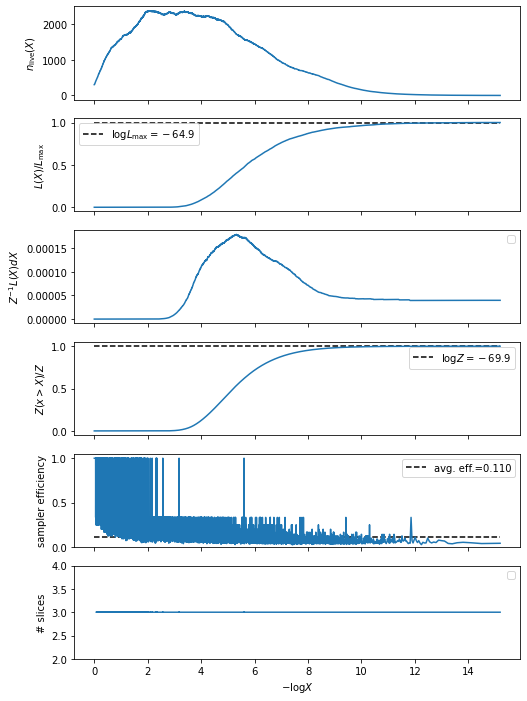

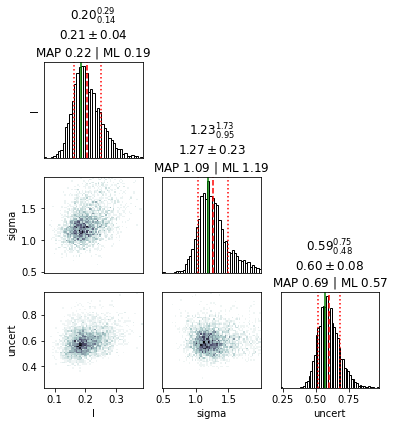

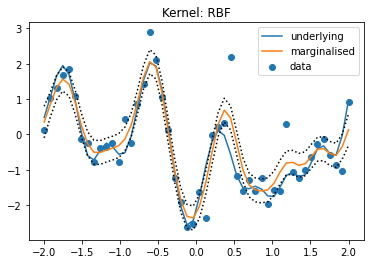

WARNING[2022-04-06 17:05:51,340]: Increasing max_samples (100000) by 200 to evenly divide samples_per_step


Working on Kernel: M12
--------
Termination Conditions:
Evidence uncertainty low enough
--------
# likelihood evals: 62678
# samples: 8400
# likelihood evals / sample: 7.5
--------
logZ=-70.142 +- 0.049
H=5.3e-30
ESS=2663
--------
l: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
l: 0.37 +- 0.18 | 0.2 / 0.32 / 0.61 | 0.46 | 0.24
--------
sigma: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sigma: 1.42 +- 0.23 | 1.15 / 1.39 / 1.78 | 1.36 | 1.3
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.22 +- 0.16 | 0.04 / 0.19 / 0.45 | 0.27 | 0.03
--------


WARNING[2022-04-06 17:06:27,636]: No handles with labels found to put in legend.
WARNING[2022-04-06 17:06:27,811]: No handles with labels found to put in legend.


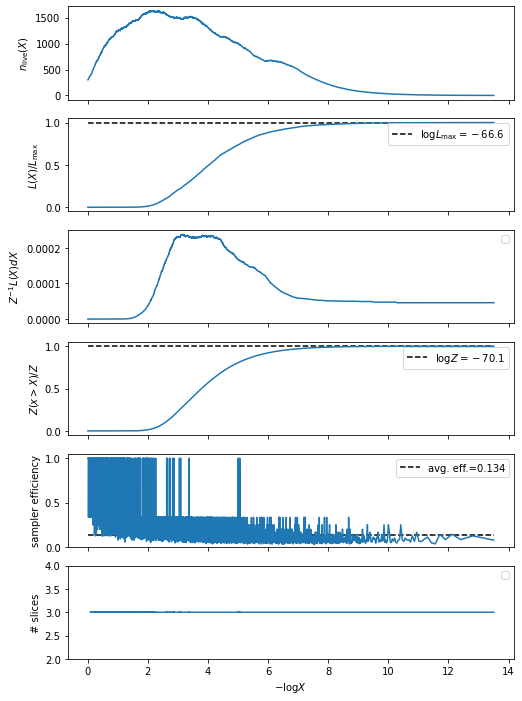

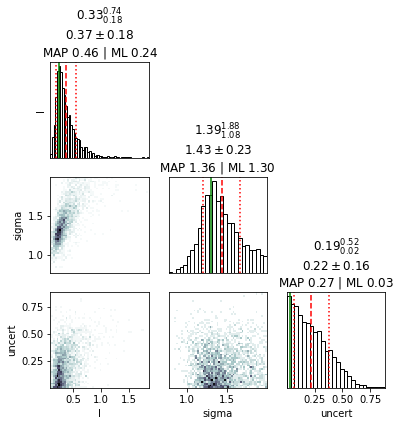

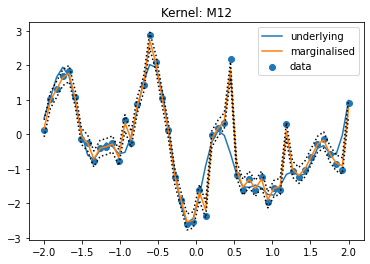

WARNING[2022-04-06 17:06:56,704]: Increasing max_samples (100000) by 200 to evenly divide samples_per_step


Working on Kernel: M32
--------
Termination Conditions:
Evidence uncertainty low enough
--------
# likelihood evals: 104869
# samples: 12300
# likelihood evals / sample: 8.5
--------
logZ=-70.289 +- 0.05
H=1.2e-29
ESS=3441
--------
l: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
l: 0.27 +- 0.083 | 0.172 / 0.261 / 0.377 | 0.304 | 0.236
--------
sigma: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sigma: 1.34 +- 0.24 | 1.07 / 1.31 / 1.69 | 1.2 | 1.23
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.54 +- 0.1 | 0.42 / 0.54 / 0.66 | 0.65 | 0.53
--------


WARNING[2022-04-06 17:08:04,672]: No handles with labels found to put in legend.
WARNING[2022-04-06 17:08:04,852]: No handles with labels found to put in legend.


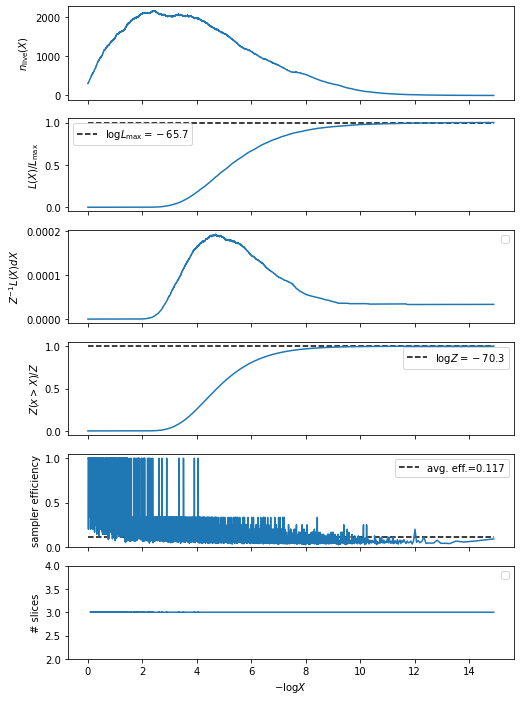

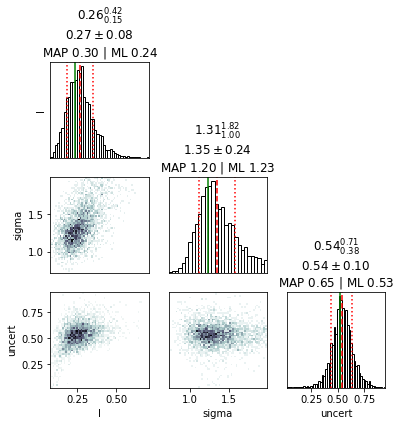

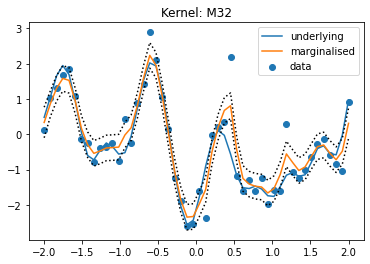

WARNING[2022-04-06 17:08:37,378]: No handles with labels found to put in legend.


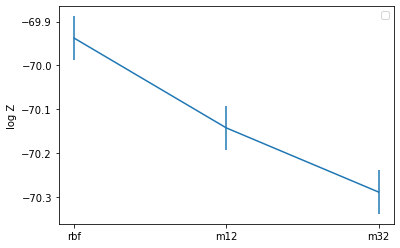

In [4]:
# Let us compare these models.

logZ_rbf, logZerr_rbf = run_for_kernel(RBF())
logZ_m12, logZerr_m12 = run_for_kernel(M12())
logZ_m32, logZerr_m32 = run_for_kernel(M32())

plt.errorbar(['rbf', 'm12', 'm32'], [logZ_rbf, logZ_m12, logZ_m32], [logZerr_rbf, logZerr_m12, logZerr_m32])
plt.ylabel("log Z")
plt.legend()
plt.show()